<a href="https://colab.research.google.com/github/ivolake/2021sem9_ml_labs/blob/main/CGZ_LW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://slides.com/romvano/lab3/fullscreen

In [ ]:
1+1

2

In [ ]:
from collections import Counter
import pickle
import operator as op

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
import plotly.express as px
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

# figsize(8, 8) # зададим размер картинки
init_notebook_mode(connected=True)
pio.renderers.default='notebook'


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, \
                            precision_score, recall_score, \
                            precision_recall_curve, roc_auc_score, f1_score, \
                            fbeta_score, auc, \
                            make_scorer

# from sklearn.tree import export_graphviz

# import os
# from glob import glob

from google.colab import drive


In [ ]:
drive.mount ('/content/drive')


Mounted at /content/drive


Импорт библиотек, подключение диска

In [ ]:
my_path = '/content/drive/MyDrive/drive' # '/content/drive/MyDrive/data'

In [ ]:
df = pd.read_csv(f'{my_path}/voice.csv')

In [ ]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
df['label'].value_counts()

female    1584
male      1584
Name: label, dtype: int64

In [ ]:
feats = list(set(df.columns) - set(['label']))

Обычное разбиение выборок

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], 
                                                    df['label'], 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=df['label'])

Создание стратегии кросс-валидации: стратифицированная с перемешиванием

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2)
# train_test_indicies = []
# for train_indices, test_indices in sss.split(df[feats], df['label']):
#     train_test_indicies.append({'train_indices': train_indices, 
#                                 'test_indices': test_indices})

Создание скорера для кросс-валидации


In [ ]:
f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better = True, pos_label='male')

In [ ]:
estimator = LogisticRegression(random_state=42)

In [ ]:
pipeline = make_pipeline(
    # FunctionTransformer(dropper, validate=False),                 # добавили удаление признаков в пайплайн;
    MinMaxScaler(),
    estimator
)
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [ ]:
scoring = cross_val_score(estimator=pipeline, 
                          X=X_test, 
                          y=y_test, 
                          scoring=f1_scorer, 
                          cv=sss)

In [ ]:
scoring.mean()

0.970659934449464

График получившегося классификатора на пространстве с пониженной размерностью

In [ ]:
# Построим график, который покажет, как обучилась логистическая регрессия.
def plot_boundary(clf, X, y):
    xx, yy = np.meshgrid(np.linspace(-40, 40, 500),
                     np.linspace(-40, 40, 500))
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1].reshape(xx.shape)
    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.Paired)
    plt.axis([-40, 40, -40, 40])
    plt.colorbar(image)
    

In [ ]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [ ]:
# print(X_train_pca[:, 0].min())
# print(X_train_pca[:, 1].min())
# print(X_test_pca[:, 0].min())
# print(X_test_pca[:, 1].min())
# print(X_train_pca[:, 0].max())
# print(X_train_pca[:, 1].max())
# print(X_test_pca[:, 0].max())
# print(X_test_pca[:, 1].max())
# -34 : 1250

In [ ]:
# Не работает, так как мерность признакового пространства больше 2. 
# Снизим мерность пространства

pipeline.fit(X=X_train_pca, y=y_train.map({'female': 1, 'male': -1}))
figsize(15, 15)

In [ ]:
scoring = cross_val_score(estimator=pipeline, 
                          X=X_test_pca, 
                          y=y_test, 
                          scoring=f1_scorer, 
                          cv=sss)
scoring.mean()

0.6167576654259929

In [ ]:
rr = pipeline.steps[1][1]

In [ ]:
rr.coef_

array([[-1.78095953,  1.98730755]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

No contour levels were found within the data range.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

The following kwargs were not used by contour: 'linetypes'



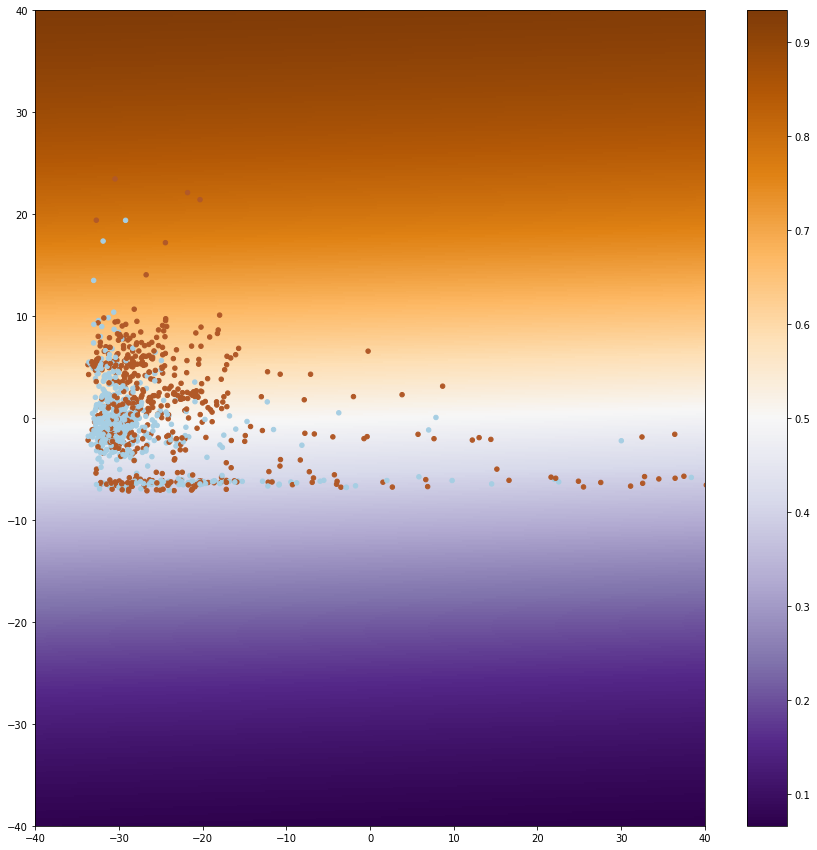

In [ ]:
plot_boundary(pipeline, X_test_pca, y_test.map({'female': 1, 'male': -1}))

Как видно, с помощью PCA выявить пространство признаков, в котором объекты выборки будут явно разделены, не получилось

Вклад признаков

In [ ]:
estimator = LogisticRegression(random_state=42, penalty='l2', solver='lbfgs')
pipeline = make_pipeline(
    # FunctionTransformer(dropper, validate=False),                 # добавили удаление признаков в пайплайн;
    MinMaxScaler(),
    estimator
)
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [ ]:
pipeline.fit(X=X_train, y=y_train.map({'female': 1, 'male': -1}))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [ ]:
rr = pipeline.steps[1][1]

In [ ]:
l2_coefs = rr.coef_[0]

In [ ]:
def plot_features_coefs(x, y):
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(111)
  ax.bar(x, height=y, label='Вклад признаков')
  ax.tick_params(axis='x', which='major', rotation=45)
  plt.legend()
  plt.show()

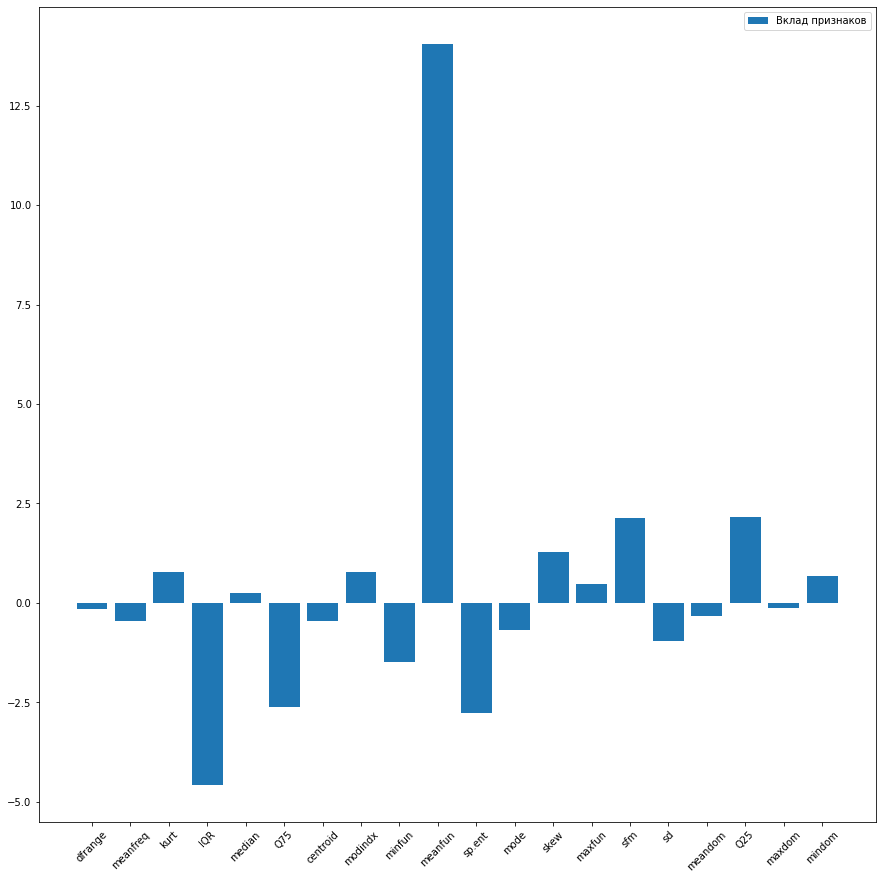

In [ ]:
plot_features_coefs(X_test.columns, l2_coefs)

L1 регуляризация (выше была L2 - так как она задается по умолчанию)

In [ ]:
estimator = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
pipeline = make_pipeline(
    # FunctionTransformer(dropper, validate=False),                 # добавили удаление признаков в пайплайн;
    MinMaxScaler(),
    estimator
)
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [ ]:
pipeline.fit(X=X_train, y=y_train.map({'female': 1, 'male': -1}))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [ ]:
rr = pipeline.steps[1][1]

In [ ]:
l1_coefs = rr.coef_[0]

In [ ]:
rr.n_iter_

array([23], dtype=int32)

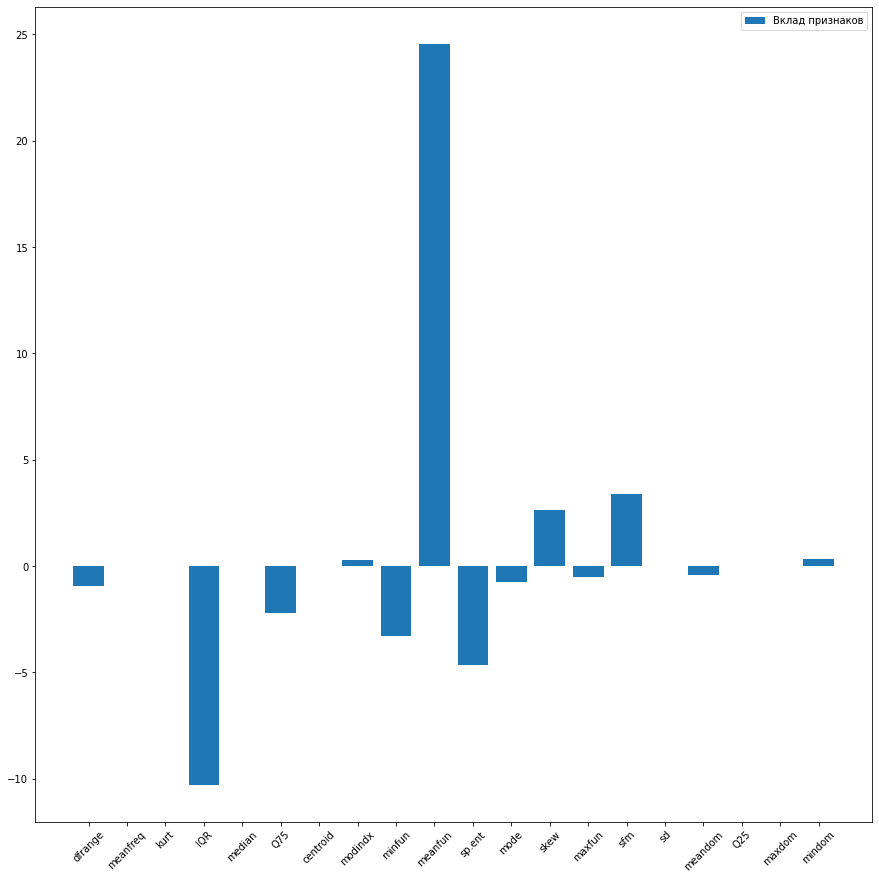

In [ ]:
plot_features_coefs(X_test.columns, l1_coefs)

Оптимальным *C*  можнос считать максимальный вес по модулю 

In [ ]:
C_opt_l2 = l2_coefs.max()
C_opt_l1 = l1_coefs.max()

In [ ]:
print(f'C_opt_l2: {C_opt_l2}')
print(f'C_opt_l1: {C_opt_l1}')

C_opt_l2: 14.051776680403103
C_opt_l1: 24.55718542343419
